## Airline Sentiment Analysis

The solution is divided into the following sections: 
- Data understanding and exploration
- Data Preprocessing
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
Tweet= pd.read_csv("Tweets.csv")
Tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [19]:
Tweet.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [20]:
Tweet = Tweet.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis=1)

In [21]:
Tweet.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [22]:
Tweet['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

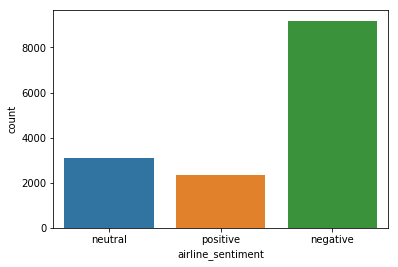

In [23]:
sns.countplot(x='airline_sentiment', data=Tweet)

In [24]:
Tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

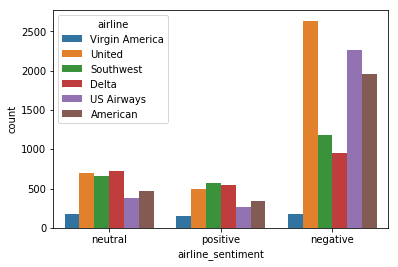

In [25]:
sns.countplot(x='airline_sentiment', hue='airline', data=Tweet)

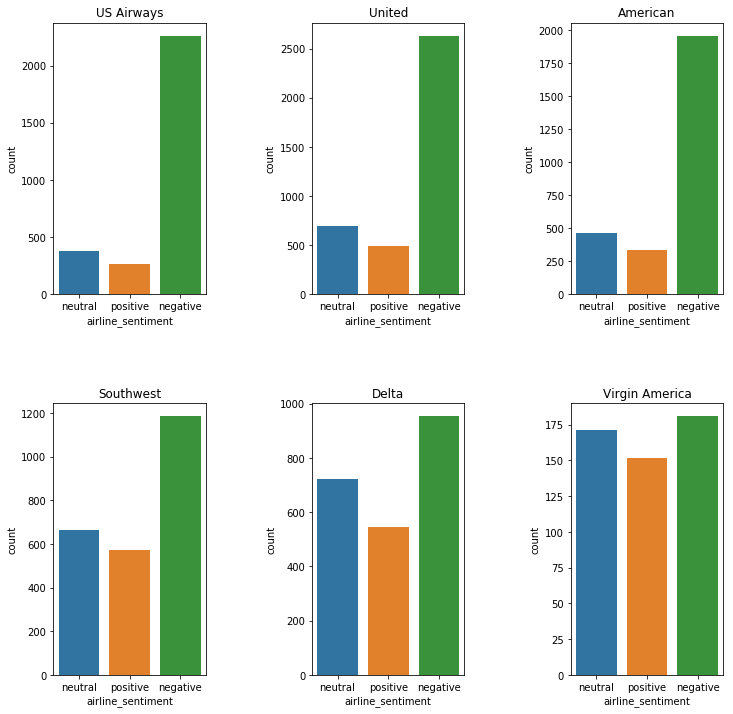

In [30]:
def plot_sub_sentiment(Airline):
    df=Tweet[Tweet['airline']==Airline]
    sns.countplot(x='airline_sentiment', order=['neutral', 'positive', 'negative'], data=df)
    plt.title(Airline)
plt.figure(1,figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.7)
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

From the above plots one can find that the distribution of sentiment for the first three airlines are always skewed toward negative. On contrary, the sentiment are distributed more balanced with the later three airline companies. 

#### Word Cloud for the negative Tweets

In [39]:
from wordcloud import WordCloud,STOPWORDS

In [40]:
df=Tweet[Tweet['airline_sentiment']=='negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [41]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

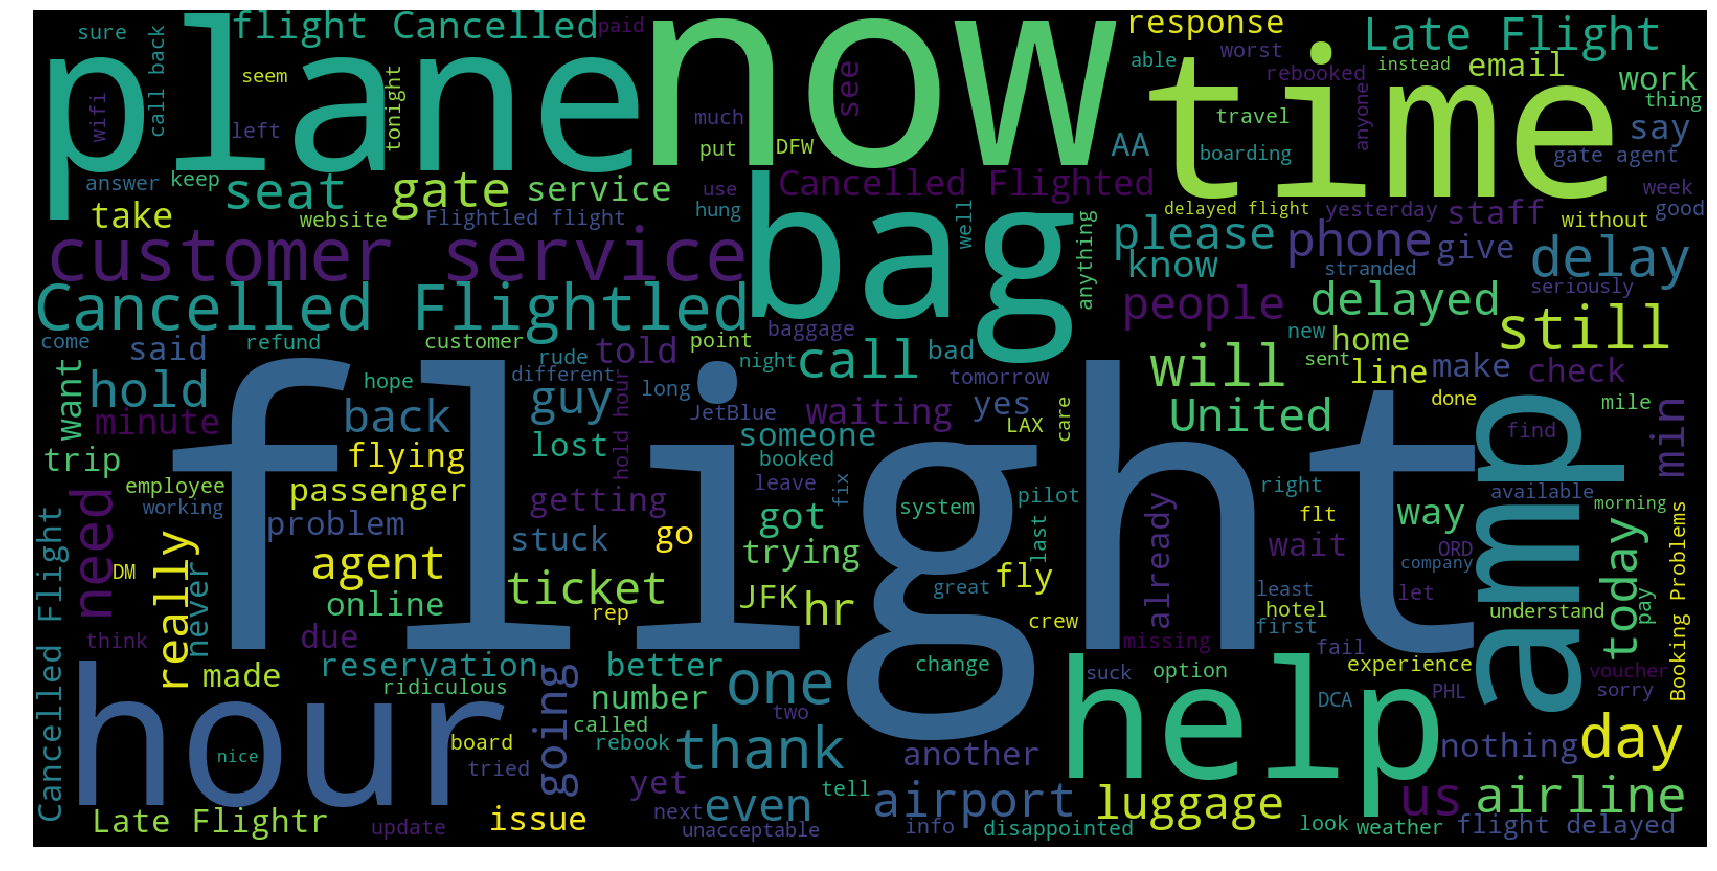

In [43]:
plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**We can find that the Tweets with negative sentiment frequently involved some words like cancelled, flight ,customer or hour. People might guess that customer tends to complain when they are waiting for the delayed flights.**

## 2. Data Preprocessing

**Our data exploration ends up at here. The next step will be preprocess the data in order to make the learning process more smooth.**

Preprocessing steps:
- Convert sentence into lower case
- Remove Stop Words
- Stemming
    
 

In [56]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [65]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [60]:
def preprocess(raw_tweet, flag):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet)
    
    # change sentence to lower case
    letters_only = letters_only.lower()

    # tokenize into words
    words = letters_only.split()
    
    # remove stop words                
    words = [w for w in words if not w in stopwords.words("english")]
    
    #Stemming
    words = [stemmer.stem(word) for word in words]
    
    if flag == 1:
        return(" ".join(words))
    else:
        return(len(words))

Stemming makes sure that different variations of a word, say ‘warm’, warmer’, ‘warming’ and ‘warmed,’ are represented by a single token - ‘warm’, because they all represent the same information (represented by the 'stem' of the word).

In [61]:
Tweet['sentiment']=Tweet['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [66]:
Tweet['clean_tweet']=Tweet['text'].apply(lambda x: preprocess(x, flag=1))
Tweet['Tweet_length']=Tweet['text'].apply(lambda x: preprocess(x, flag=2))

## 3. Data Preparation 

Let's now prepare the data and build the model.

In [81]:
Tweet.head()

,airline_sentiment,airline,text,sentiment,clean_tweet,Tweet_length
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,1,virginamerica dhepburn said,3
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,1,virginamerica plu ad commerci experi tacki,6
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,1,virginamerica today must mean need take anoth ...,8
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,0,virginamerica realli aggress blast obnoxi ente...,11
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,0,virginamerica realli big bad thing,5


In [68]:
# splitting into test and train

from sklearn.model_selection  import train_test_split

train,test = train_test_split(Tweet,test_size=0.2,random_state=42)

In [69]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

**Text to vector using Bag of Words**

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

## 4. Model Building and Evaluation

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [76]:
Classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

In [80]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
for classifier in Classifiers:
    fit = classifier.fit(dense_features,train['sentiment'])
    pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['sentiment'])
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))    

Accuracy of LogisticRegression is 0.8292349726775956
Accuracy of DecisionTreeClassifier is 0.7578551912568307
Accuracy of RandomForestClassifier is 0.8183060109289617
